In [1]:
import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)

from clipppy import load_config, Clipppy
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML
import pyro.distributions as dist

import swyft

import matplotlib.pyplot as plt
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')

import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *

from matplotlib.colors import LogNorm


In [2]:
SYSTEM_NAME = "ngc4414"
SOURCE_DIR = '../../mock_data/sources'
source_name = f'{SYSTEM_NAME}.npy'
config_1 = load_config('config_sub_testing_1.yaml', base_dir=SOURCE_DIR)
# config_2 = load_config('config_sub_testing_2.yaml', base_dir=SOURCE_DIR)
model_1 = config_1.umodel
# plot_imshow([model_1() - model_1(), model_1()], colorbar = True)

In [3]:
SOURCE_DIR

'../../mock_data/sources'

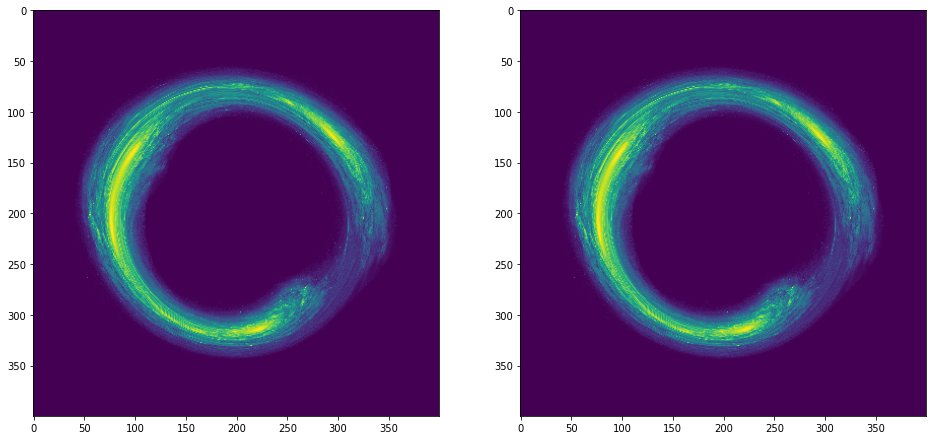

In [5]:
plot_imshow(model_1())

In [21]:
model_1 = config_1.umodel
model_2 = config_2.umodel

In [22]:
plot_imshow([model_1() - model_1(), model_2() - model_2()], colorbar = True)

ValueError: The parameter scale has invalid values

In [ ]:
model_1

### Utilities

In [8]:
def get_config(system_name: str) -> Clipppy:
    """
    Get configuration
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

    SOURCE_DIR = '../../mock_data/sources'
        
    source_name = f'{system_name}.npy'
    config = load_config('config_sub.yaml', base_dir=SOURCE_DIR)

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return config


def get_prior(config: Clipppy):
    """
    Set up subhalo parameter priors using a config
    """
    main = config.umodel.alphas["main"]
    prior_p_sub = main.sub.pos_sampler.base_dist
    lows = np.array(
        [
            prior_p_sub.low[0].item(),
            prior_p_sub.low[1].item(),
        ]
    )
    highs = np.array(
        [
            prior_p_sub.high[0].item(),
            prior_p_sub.high[1].item(),
        ]
    )
    
#     print(lows)
#     print(highs)
    
    return swyft.Prior(lambda u: (highs - lows) * u + lows, 2)


def simul(v, config: Clipppy):
    """
    Fix values for main lens and source parameters from config and put
    in a subhalo with the specified position and mass.

    Arguments
    - v: array containing x_sub, y_sub.

    Returns
    - Numpy array.
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
    
    from pyrofit.lensing.utils import get_meshgrid  # import here due to HACKs
    nx = config.kwargs["defs"]["nx"]
    ny = config.kwargs["defs"]["ny"]
    res = config.kwargs["defs"]["res"]
    X, Y = config.umodel.X.clone(), config.umodel.Y.clone()
    # Upsample image
    upsample = 10
    config.umodel.coerce_XY(*get_meshgrid(res / upsample, nx * upsample, ny * upsample))
        
    x_sub, y_sub = np.squeeze(v.T)
    d_p_sub = dist.Delta(torch.tensor([x_sub, y_sub])).to_event(1)

    def _guide():
        # Sample subhalo position
        guide_sample = {
            "main/sub/p_sub": pyro.sample("main/sub/p_sub", d_p_sub),
        }

        return guide_sample
    
    result = {
        "image": CONFIG.ppd(guide=_guide)["model_trace"]
        .nodes["mu"]["value"]
        .detach()
        .numpy()
    }
    
    # Restore coarse grid
    config.umodel.coerce_XY(X, Y)
    # Downsample image
    averager = torch.nn.AvgPool2d((upsample, upsample))
    result['image'] = (averager(torch.tensor(result['image']).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0))

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return result

def noise(obs, _=None, sigma_n=SIGMA):
    image = obs["image"]
    eps = np.random.randn(*image.shape) * sigma_n
    return {"image": image + eps}


### Check utilities

In [11]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK # rest is using this
CONFIG = get_config(SYSTEM_NAME)
torch.set_default_tensor_type(torch.FloatTensor) # swyft is using this

In [14]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
ppd = CONFIG.ppd()['model_trace'].nodes
ppd1 = CONFIG.ppd()['model_trace'].nodes
ppd2 = CONFIG.ppd()['model_trace'].nodes
ppd3 = CONFIG.ppd()['model_trace'].nodes
ppds = [ppd1, ppd2, ppd3]
torch.set_default_tensor_type(torch.FloatTensor)

In [18]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
CONFIG.ppd()['model_trace'].nodes

OrderedDict([('main/sub/m_sub',
              {'type': 'sample',
               'name': 'main/sub/m_sub',
               'fn': ExtraIndependent(),
               'is_observed': False,
               'args': (),
               'kwargs': {},
               'value': tensor([1.0000e+09]),
               'infer': {},
               'scale': 1.0,
               'mask': None,
               'cond_indep_stack': (),
               'done': True,
               'stop': False,
               'continuation': None}),
             ('main/sub/p_sub',
              {'type': 'sample',
               'name': 'main/sub/p_sub',
               'fn': ExtraIndependent(),
               'is_observed': False,
               'args': (),
               'kwargs': {},
               'value': tensor([[-2.1733,  1.6851]]),
               'infer': {},
               'scale': 1.0,
               'mask': None,
               'cond_indep_stack': (),
               'done': True,
               'stop': False,
             

`Xsrc` and `Ysrc`: one of the points in difference is the subhalo position of `i`, the other point is the subhalo position of `j`

`image` and `mu`: difference is Gaussian noise. See some residue of lens itself because Gaussian noise is dependent on `mu` at that pixel.

###### Xsrc #####


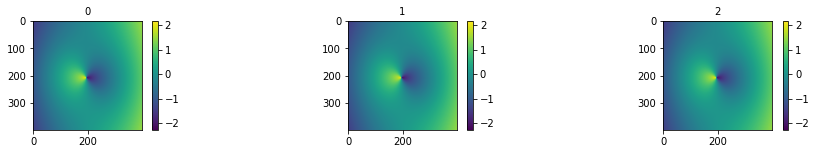

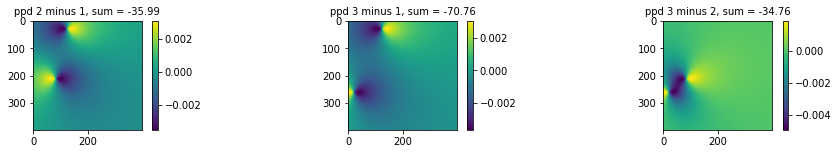

###### Ysrc #####


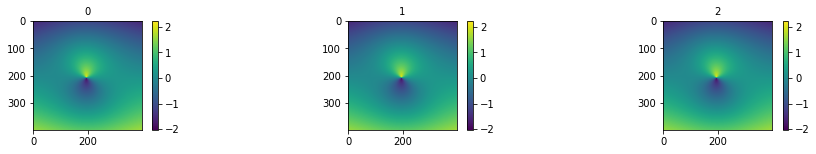

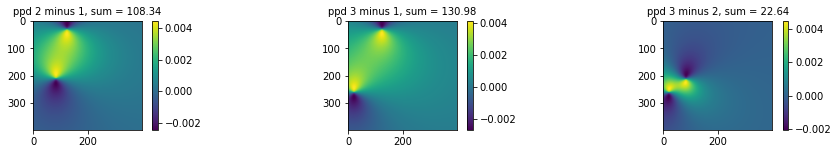

###### image #####


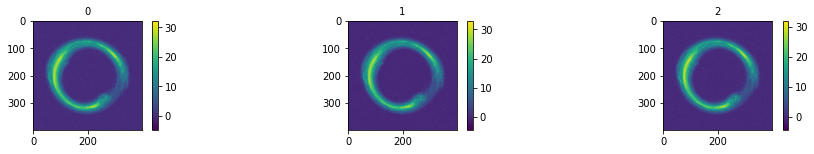

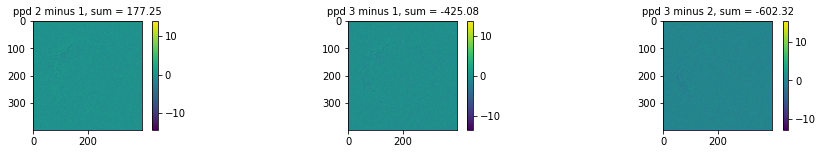

###### mu #####


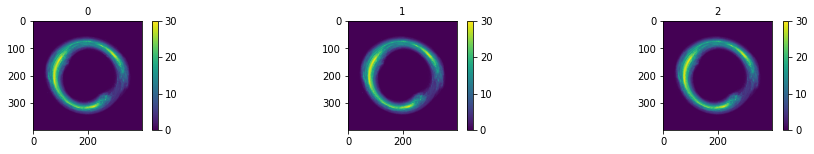

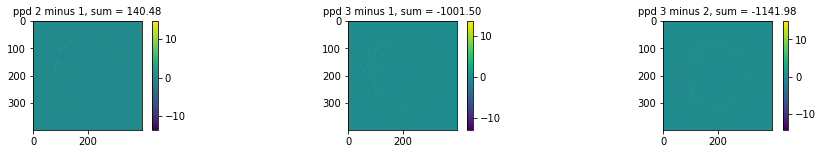

In [7]:
size_y = 2
for k, log in zip(['Xsrc', 'Ysrc', 'image', 'mu'], [False, False, False, False]):
    print(f'###### {k} #####')
    
    
    diffs = ([])
    titles_diff = ([])
    titles = ([])
    
    for i in range(len(ppds)):
        for j in range(i):
            diff = ppds[i][k]['value'] - ppds[j][k]['value']
            diffs.append(ppds[i][k]['value'] - ppds[j][k]['value'])
            titles_diff.append(f'ppd {i+1} minus {j+1}, sum = {torch.sum(diff):.2f}')
        titles.append(i)
            
    
    plots = [ppd[k]['value'] for ppd in ppds]

        
    
        
    plot_imshow(plots, titles = titles, size_y = size_y, colorbar = True)
    
    if log: plot_imshow(diffs, norm = LogNorm(), colorbar = True, titles = titles_diff, size_y = size_y)
    else: plot_imshow(diffs, colorbar = True, titles = titles_diff, size_y = size_y)
    


In [8]:
for k in ['main/sub/m_sub', 'main/sub/p_sub']:
    print(f'### {k} ###')
    for p in ppds:
        print(p[k]['value'])
    print()

### main/sub/m_sub ###
tensor([1.0000e+09], device='cuda:0')
tensor([1.0000e+09], device='cuda:0')
tensor([1.0000e+09], device='cuda:0')

### main/sub/p_sub ###
tensor([[-0.9413, -2.1410]], device='cuda:0')
tensor([[-1.4482,  0.1472]], device='cuda:0')
tensor([[-2.2272,  0.7770]], device='cuda:0')



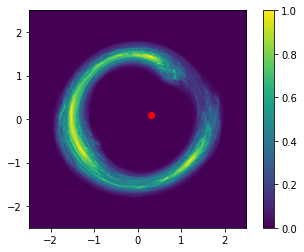

In [9]:
v = torch.tensor([0.3, 0.1]) # just a check, not adding a 'true' value or something
plt.imshow(simul(v, CONFIG)['image'], **imkwargs)
plt.scatter(*v.t(), c="r")
plt.colorbar()
plt.show()

### Simulate

In [51]:
prior = get_prior(CONFIG)
nx = CONFIG.kwargs["defs"]["nx"]
ny = CONFIG.kwargs["defs"]["ny"]

As one can see below, all values outside [0,1] are going to infinity. That part (tab[5000:7000]) is being mapped with the Prior $y = (2.5 - -2.5)\times u - 2.5 = 5\times u - 2.5$

/scratch/ipykernel_18547/631170303.py:5: RuntimeWarning: invalid value encountered in subtract
  plots = [tab, v0[0:5000], v0[5000:7000], v0[7000:10000], v.T[0] - v.T[1]]


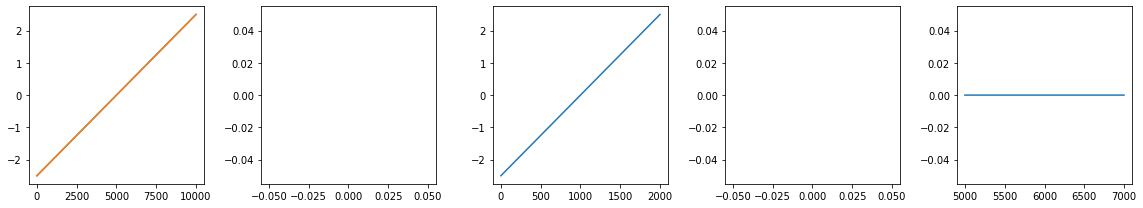

In [50]:
tab = prior._table.T
v = prior.v(tab)
v0 = v.T[0] 

plots = [tab, v0[0:5000], v0[5000:7000], v0[7000:10000], v.T[0] - v.T[1]]
plot_plot(plots, size_y = 3)

# print(v0[4990:5010])
# print(v0[6990:7010])
# print([np.sum(plot) for plot in plots])

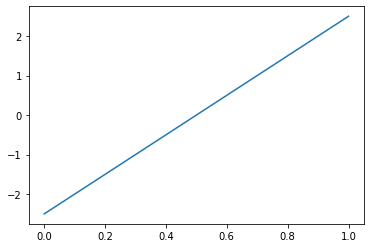

In [60]:
lows = np.array([-2.5, -2.5])
highs = np.array([2.5, 2.5])
p = lambda u: (highs - lows) * u + lows
x = np.linspace((0,0), (1,1))
plt.plot(x.T[0], p(x).T[0])

In [62]:
simulator = swyft.Simulator(model = lambda v: simul(v, CONFIG), 
                            pnames = ["x_sub", "y_sub"],
                            sim_shapes={"image": (nx, ny)})

store = swyft.DirectoryStore(path=SIM_PATH, simulator=simulator)
 
store.add(NSIM, prior)
store.simulate()

Loading existing store.


### Check store

In [63]:
store = swyft.DirectoryStore(path=SIM_PATH)
len(store)

Loading existing store.


10066

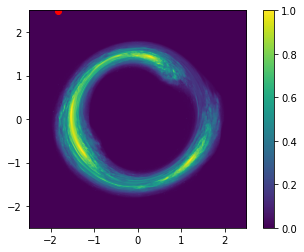

In [64]:
idx = 1 # because of __getitem__
plt.imshow(store[idx][0]['image'], **imkwargs)
plt.scatter(*store[idx][1], c="r")
plt.colorbar()

difference is because of subhalos

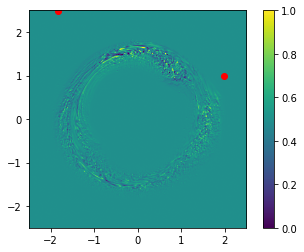

In [65]:
plt.imshow(store[1][0]['image']-store[-1][0]['image'], vmin = -2, vmax = 2, **imkwargs) # just a check
plt.scatter(*store[1][1], c="r")
plt.scatter(*store[-1][1], c="r")
plt.colorbar()

### Train

In [21]:
class DownsampleLinearHead(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        image_shape = obs_shapes["image"]
        self.onl_f = swyft.networks.OnlineNormalizationLayer(
            image_shape, use_average_std=False
        )

        self.factor = 8
        downscaled_image_shape = (
            image_shape[0] // self.factor,
            image_shape[1] // self.factor,
        )
        self.avg2d = torch.nn.AvgPool2d((self.factor, self.factor))

        self.n_features = 8
        self.layers = torch.nn.Linear(np.prod(downscaled_image_shape), self.n_features)

    def forward(self, obs):
        x = obs["image"]
        nbatch = len(x)
        x = self.onl_f(x)
        x = self.avg2d(x.unsqueeze(1)).squeeze(1)
        x = self.layers(x.view(nbatch, -1))
        return x

In [22]:
dataset = swyft.Dataset(NSIM, prior, store, simhook = noise)
post = swyft.Posteriors(dataset)

In [16]:
# marginals = [(0, 1)]  #, (0,), (1,)]
# post.add(
#         marginals,
#         head=DownsampleLinearHead,
#         device="cuda",
#     )

# post.train(marginals)

In [23]:
net = 'net.pt'
# post.save(net)
post = swyft.Posteriors.load(net).to('cuda')

### Check posteriors

In [24]:
post = swyft.Posteriors.load(net).to('cuda')

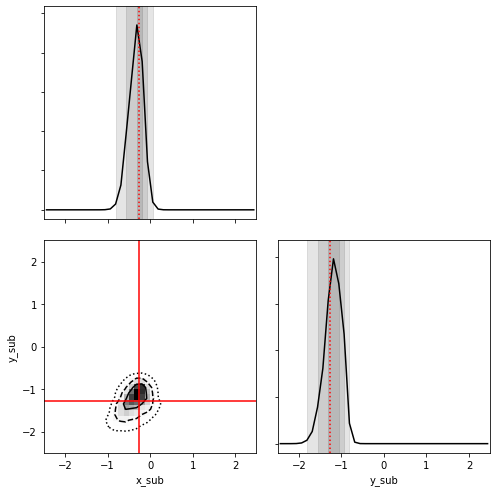

In [26]:
torch.set_default_tensor_type(torch.FloatTensor)  # HACK
idx = 5 # choose different observation 
IMAGE = store[idx][0]["image"]
v0 = store[idx][1]
samples = post.sample(100000, {"image": IMAGE})

swyft.plot_corner(
    samples, 
    [0, 1], 
    color='k', 
    figsize = (8,8), 
    truth=v0, 
    bins = 40);

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

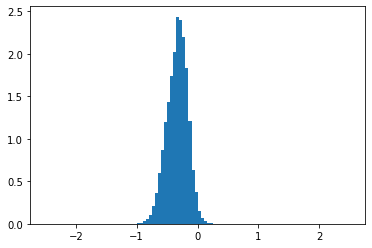

In [27]:
plt.hist(samples['v'][:,0], weights = samples['weights'][(0,1)], density = True, bins = 100);